# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO (PRE-COVID)
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor

# Preparación de los datos

Definimos las fechas de inicio y fin de train y test

In [24]:
fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2023-01-01'
fecha_inicio_test = '2023-01-02'
fecha_fin_test = '2023-05-01'

Obtenemos los datos de train

In [25]:
datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [26]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [27]:
scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

(3150, 1) (3272, 1) (3028, 1) (3272, 1)


Definimos una función para crear datos de train y test

In [28]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [7]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

Descagramos datos nuevos (test) para gráficar y hacer pruebas.

In [29]:
datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Modelos de aprendizaje automático

Usaremos las sigueintes métricas para evaluar los modelos:
   * RMSE (raíz del error cuadrático medio): esta métrica es útil para evaluar la precisión de la predicción del modelo en la misma escala que los valores de la variable objetivo.

   * MSE (error cuadrático medio): al igual que el RMSE, el MSE mide la precisión de la predicción del modelo. Sin embargo, como los errores están al cuadrado, el MSE puede dar más peso a los errores grandes.

   * MAE (error absoluto medio): esta métrica es una buena opción para evaluar la precisión de la predicción en una escala fácil de interpretar. El MAE es la media de las diferencias absolutas entre las predicciones y los valores reales.

   * R2 SCORE (coeficiente de determinación): esta métrica mide la proporción de la varianza en los valores de la variable objetivo que se explica por el modelo. Es una medida útil para evaluar el ajuste del modelo en general.


### Evaluación de los modelos

In [9]:
def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

### Funciones para las predicciones continuas

In [10]:
def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:11], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:10], label=name, color='blue')
    ax.set_title(name)

In [11]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

In [12]:
def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

## Regresión Lineal

### Preparación de datos

In [13]:
pasos = 2 # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

### Entrenamiento

In [14]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_bitcoin = LinearRegression()
model_lr_bitcoin.fit(x_train_bitcoin_reg, y_train_bitcoin)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  0.5915394021054414
MSE:  0.3499188642432632
MAE:  0.4141577080532362
R²:  0.9457007880691689


SP500 (^GSPC)
RMSE:  21.239590661038118
MSE:  451.12021144845767
MAE:  15.590974005182355
R²:  0.961216570001671


Bitcoin (BTC-USD)
RMSE:  189.5886560074122
MSE:  35943.858486696874
MAE:  102.7447327877929
R²:  0.983204883456699


Petroleo (CL=F)
RMSE:  1.0074674247513031
MSE:  1.0149906119350227
MAE:  0.7609222206106969
R²:  0.9518089370217551




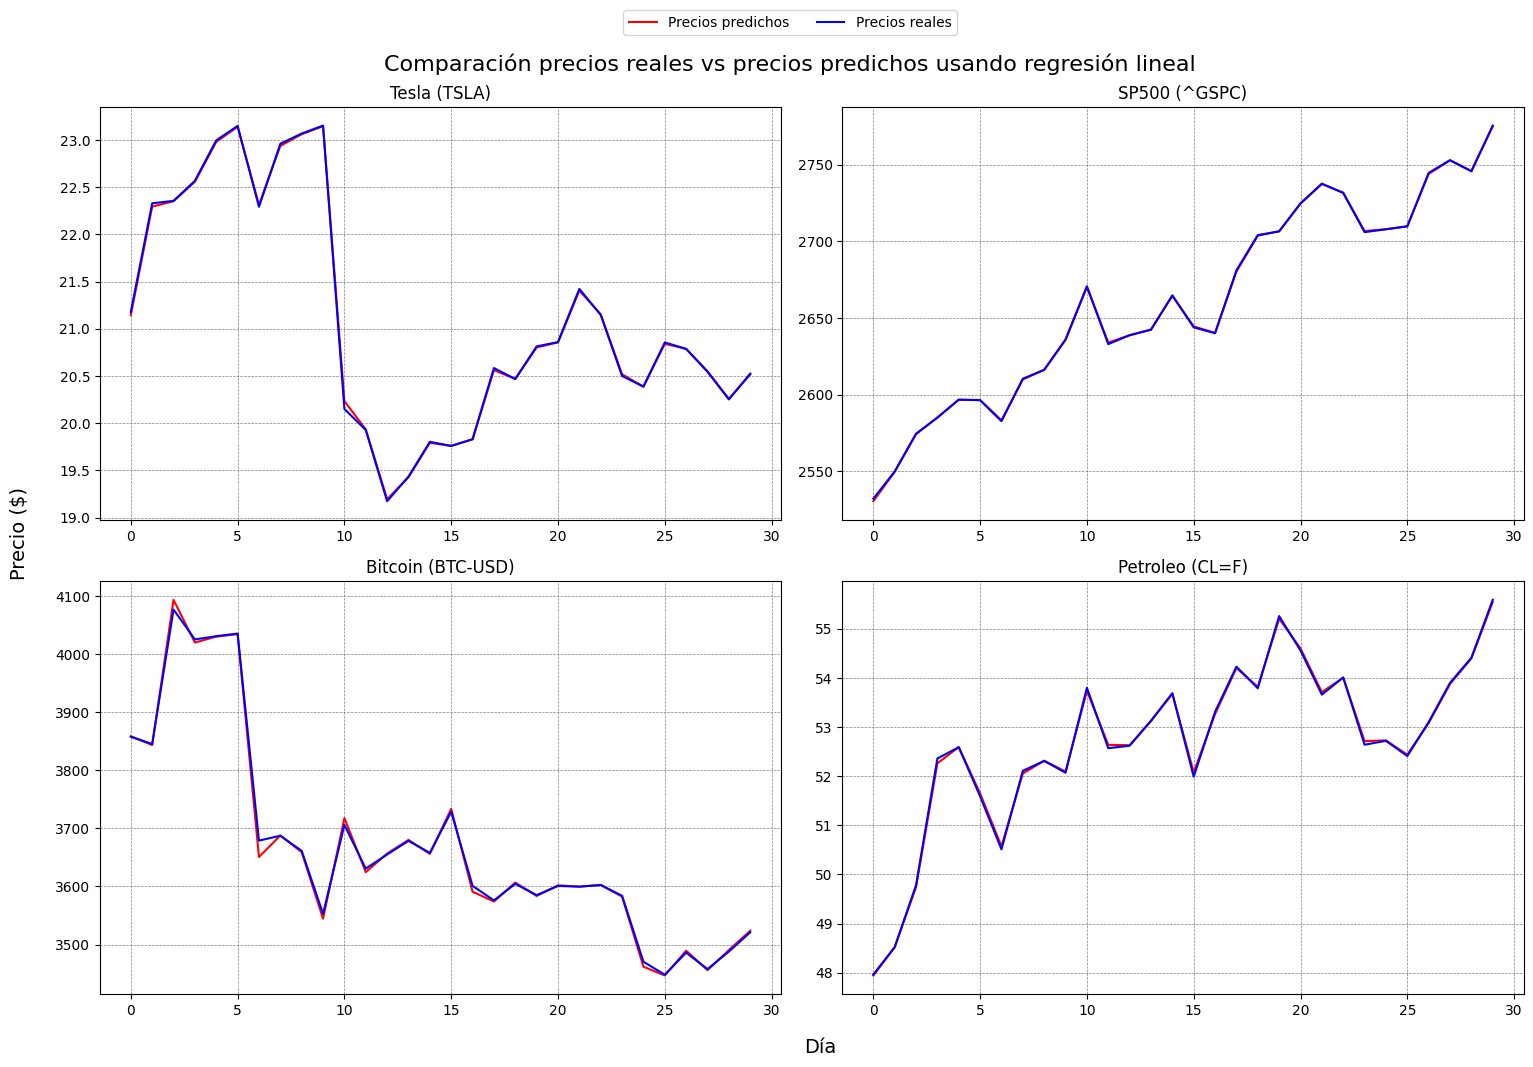

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_lr_bitcoin.predict(x_bitcoin_t_reg) 
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  2.1677879174203567
MSE:  4.699304454913688
MAE:  1.8393942209295255
R²:  -765554.7132993813


SP500 (^GSPC)
RMSE:  161.6300681875081
MSE:  26124.27894229852
MAE:  157.1790284577866
R²:  -20016.65522183469


Bitcoin (BTC-USD)
RMSE:  172.600715371676
MSE:  29791.00694681431
MAE:  159.02945014046023
R²:  -2650.2326921073504


Petroleo (CL=F)
RMSE:  4.765038247055625
MSE:  22.705589495902945
MAE:  4.478948627956764
R²:  -3029.7010251468164




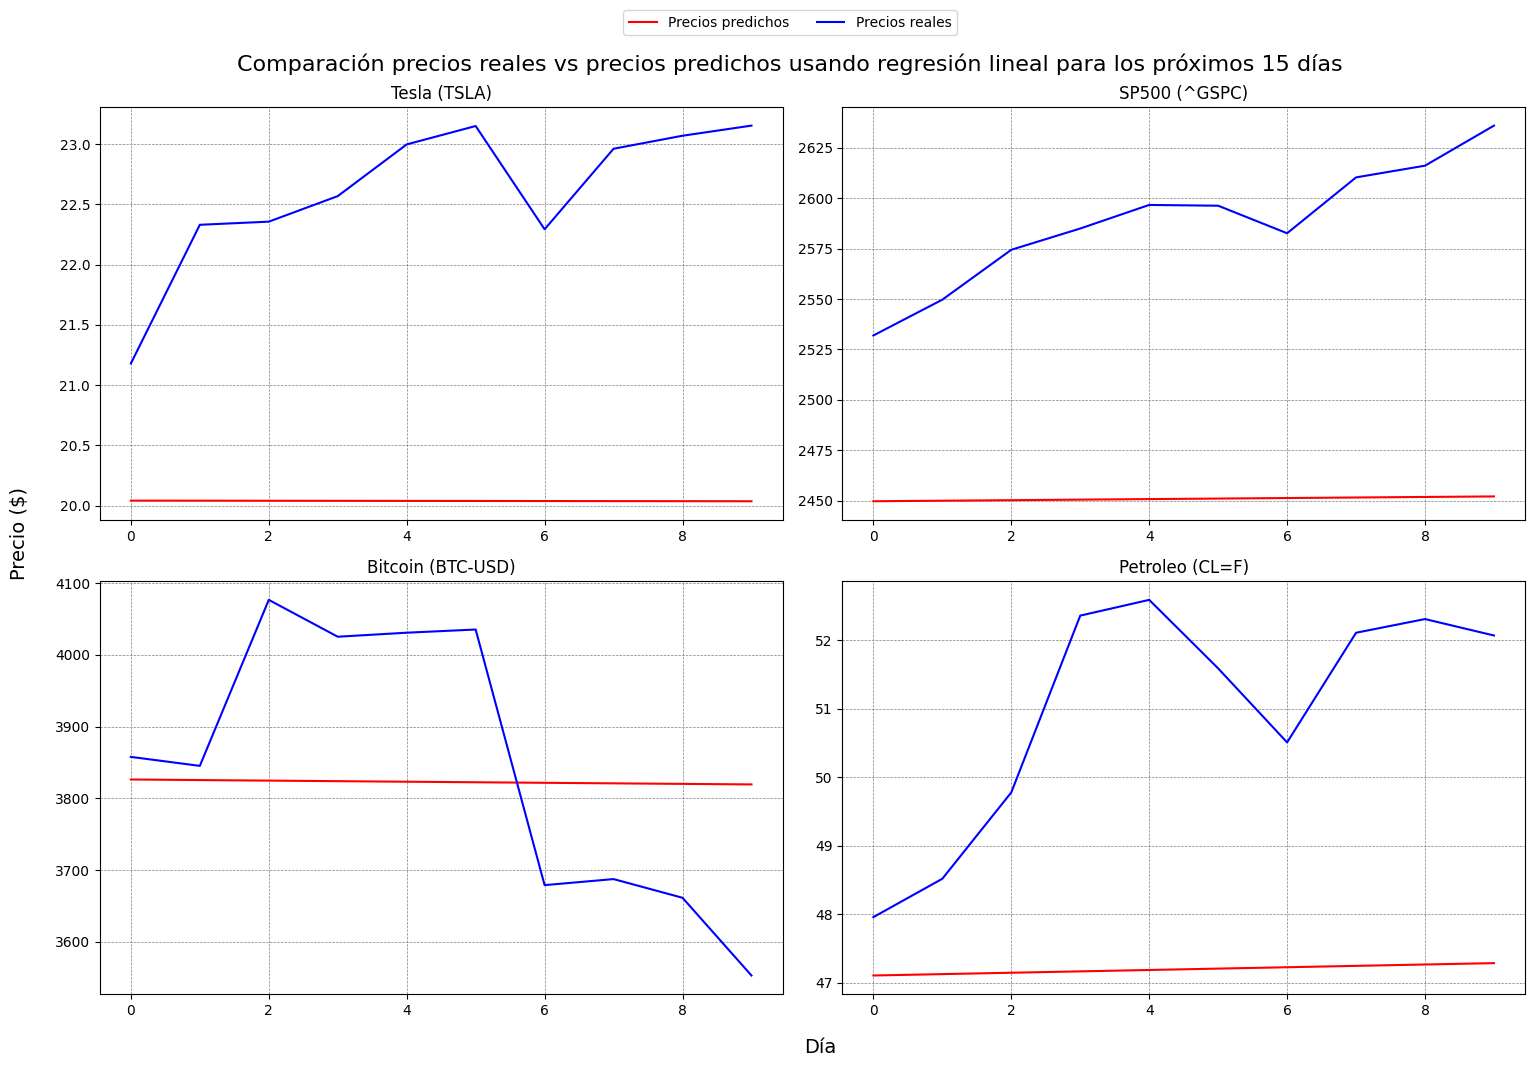

In [16]:
ventana = pasos
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:ventana], ventana, dias, model_lr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

Volvemos a preparar los datos ya que este modelo empelará una ventana diferente:

In [17]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 10
pasos_sp500 = 5
pasos_bitcoin = 10
pasos_petroleo = 10

y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)


In [18]:
param_grid = {'C': [1, 10, 100, 200, 300, 500, 600, 800, 1000, 1500, 2000, 3500, 4000, 4500, 10000, 20000, 30000, 40000, 50000, 60000, 61000], 
              'gamma': [1, 0.1, 0.2, 0.4, 0.8, 0.001,0.002,0.004,0.006, 0.0008, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 
              'kernel': ['linear', 'rbf']}

model_svr_tesla = SVR()
grid_search = GridSearchCV(model_svr_tesla, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_tesla_reg, np.ravel(y_train_tesla))
model_svr_tesla = grid_search.best_estimator_
best_params_tesla_svr = grid_search.best_params_

print("Mejores parámetros para Tesla: ", grid_search.best_params_)
print("Mejor resultado para Tesla: ", grid_search.best_score_)


model_svr_sp500 = SVR()
grid_search = GridSearchCV(model_svr_sp500, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_sp500_reg, np.ravel(y_train_sp500))
model_svr_sp500 = grid_search.best_estimator_
best_params_sp500_svr = grid_search.best_params_

print("Mejores parámetros para SP500: ", grid_search.best_params_)
print("Mejor resultado para SP500: ", grid_search.best_score_)


model_svr_bitcoin = SVR()
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

print("Mejores parámetros para Bitcoin: ", grid_search.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search.best_score_)


model_svr_petroleo = SVR()
grid_search = GridSearchCV(model_svr_petroleo, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))
model_svr_petroleo = grid_search.best_estimator_
best_params_petroleo_svr = grid_search.best_params_

print("Mejores parámetros para Petróleo: ", grid_search.best_params_)
print("Mejor resultado para Petróleo: ", grid_search.best_score_)

Mejores parámetros para Tesla:  {'C': 60000, 'gamma': 1.3e-05, 'kernel': 'rbf'}
Mejor resultado para Tesla:  0.9844228287428303
Mejores parámetros para SP500:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Mejor resultado para SP500:  0.9879805141248498
Mejores parámetros para Bitcoin:  {'C': 10000, 'gamma': 0.006, 'kernel': 'rbf'}
Mejor resultado para Bitcoin:  0.9038378083742588
Mejores parámetros para Petróleo:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor resultado para Petróleo:  0.987837684886947


Tesla (TSLA)
RMSE:  0.8308295392322691
MSE:  0.6902777232609046
MAE:  0.6559535551368528
R²:  0.8313897239211634


SP500 (^GSPC)
RMSE:  109.1701253739777
MSE:  11918.116274170008
MAE:  92.57513293232088
R²:  -6.366549191026425


Bitcoin (BTC-USD)
RMSE:  544.7178955011856
MSE:  296717.5856792405
MAE:  452.39612949322543
R²:  0.8999229680798871


Petroleo (CL=F)
RMSE:  1.4579132339971388
MSE:  2.1255109978639957
MAE:  1.1548791142117887
R²:  0.8776817839681235




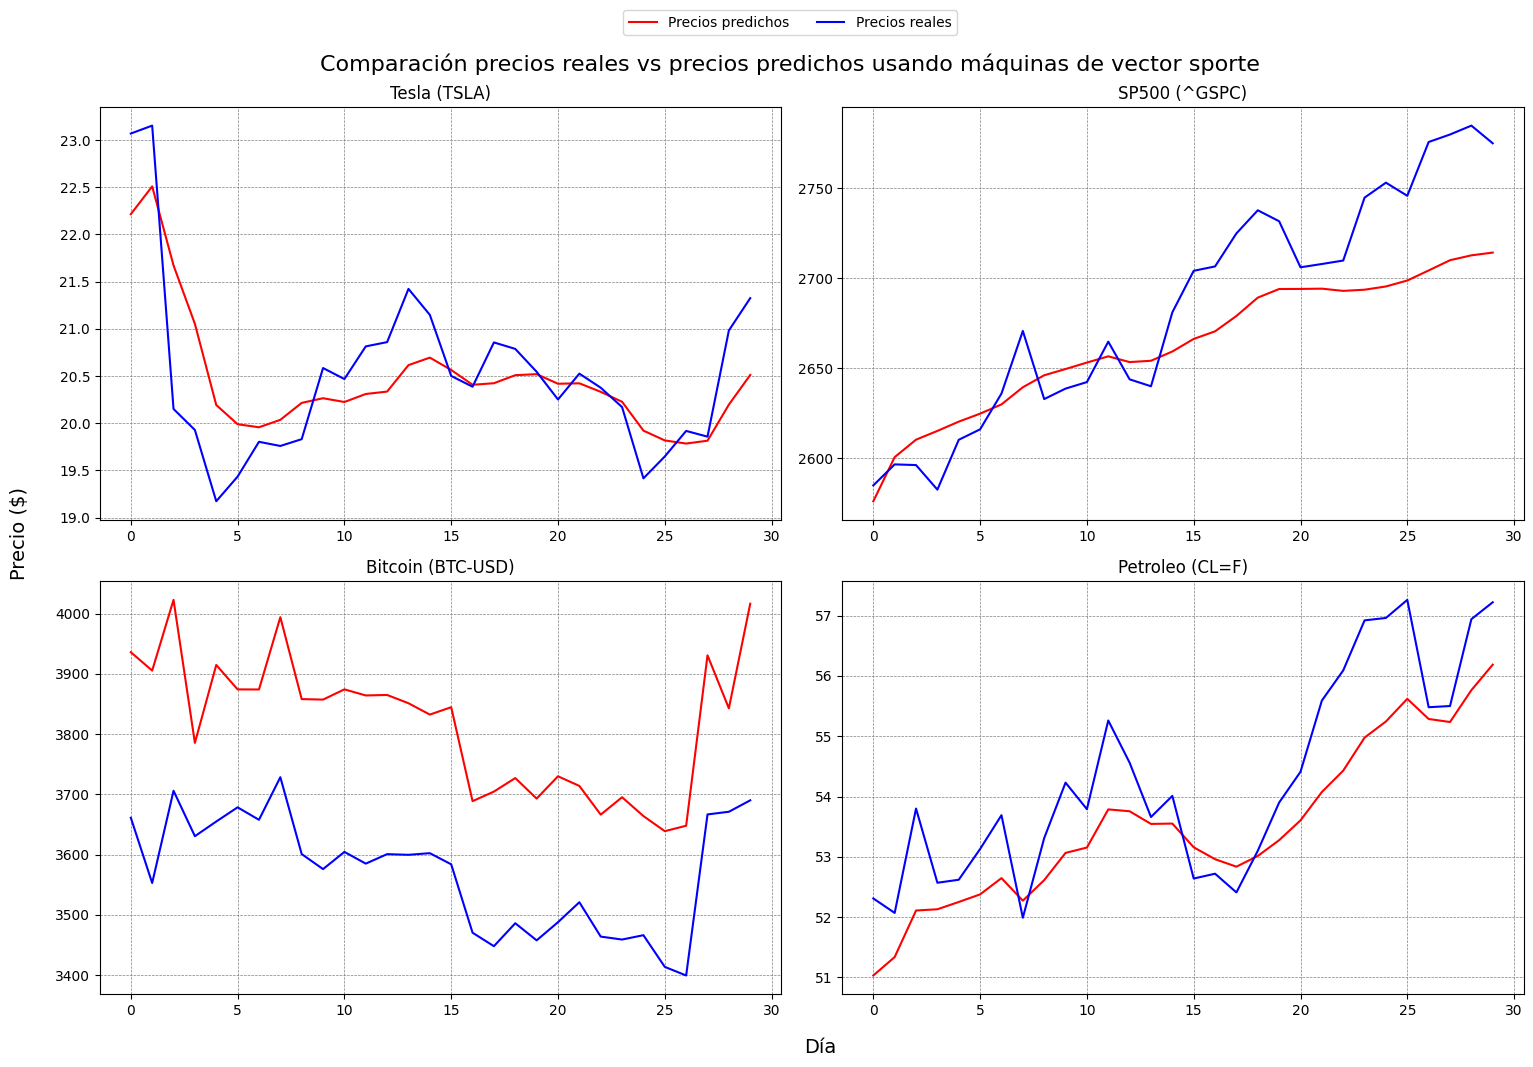

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_svr_bitcoin.predict(x_bitcoin_t_reg)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

    El modelo es demasiado simple o no es adecuado para los datos, lo que significa que no es capaz de capturar la complejidad de la relación entre las variables predictoras y la variable objetivo.

    Las características (variables predictoras) que se están utilizando no son relevantes para predecir la variable objetivo.

    La variable objetivo tiene demasiado ruido o variabilidad, lo que hace que sea difícil de predecir.

    El modelo se ha sobreajustado a los datos de entrenamiento y no generaliza bien a nuevos datos.

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  1.446182641129054
MSE:  2.0914442315030057
MAE:  1.2439407734132635
R²:  -18.317566653011166


SP500 (^GSPC)
RMSE:  16.940968229424993
MSE:  286.996404550387
MAE:  12.712667639907218
R²:  0.6304984759619534


Bitcoin (BTC-USD)
RMSE:  6244.785997245895
MSE:  38997352.151398405
MAE:  4985.393440234126
R²:  -1.7902034733718524


Petroleo (CL=F)
RMSE:  2.9699017402499766
MSE:  8.820316346739839
MAE:  2.808564048454833
R²:  -654.3121343901348




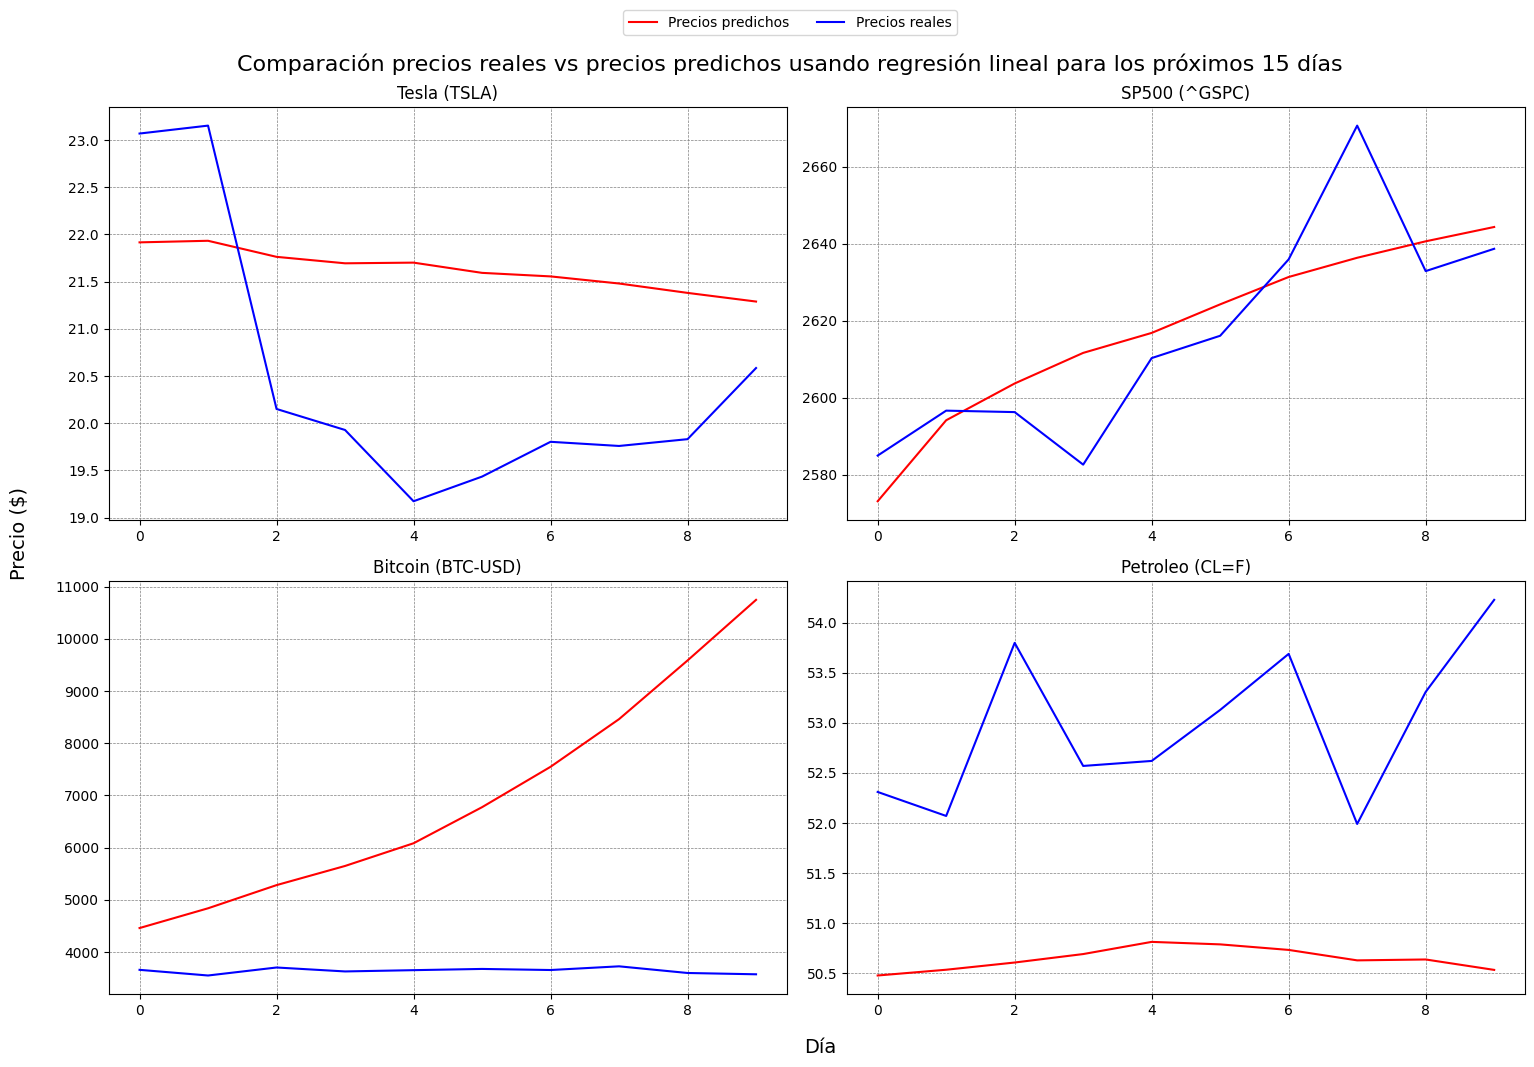

In [20]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, model_svr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

Preparamos los datos de entrenamiento

In [30]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [23]:
def create_lstm(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_tesla = KerasRegressor(build_fn=create_lstm)
lstm_sp500 = KerasRegressor(build_fn=create_lstm)
lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
lstm_petroleo = KerasRegressor(build_fn=create_lstm)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=lstm_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=lstm_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=lstm_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=lstm_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_13220\3279703967.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_tesla = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_13220\3279703967.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_sp500 = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_13220\3279703967.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer N

70/70 [==============================] - 23s 299ms/step - loss: 0.0517
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.97710400234585
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 256}
Mejor resultado para SP500:  0.990400447334301
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 256}
Mejor resultado para Bitcoin:  0.9301550055568328
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.9658326345812241


2/2 [==============================] - 0s 16ms/step
Tesla (TSLA)
RMSE:  6.566780593276882
MSE:  43.12260736023788
MAE:  5.094265208524816
R²:  0.7631687588024133


2/2 [==============================] - 0s 16ms/step
SP500 (^GSPC)
RMSE:  42.18586067435967
MSE:  1779.6468408364854
MAE:  33.23515050551466
R²:  0.7514075218370841


3/3 [==============================] - 0s 26ms/step
Bitcoin (BTC-USD)
RMSE:  819.5289304129286
MSE:  671627.6677837587
MAE:  595.3917661516854
R²:  0.9220728277793164


2/2 [==============================] - 0s 10ms/step
Petroleo (CL=F)
RMSE:  2.013593955309993
MSE:  4.054560616860943
MAE:  1.571461897629959
R²:  0.7735353364078785




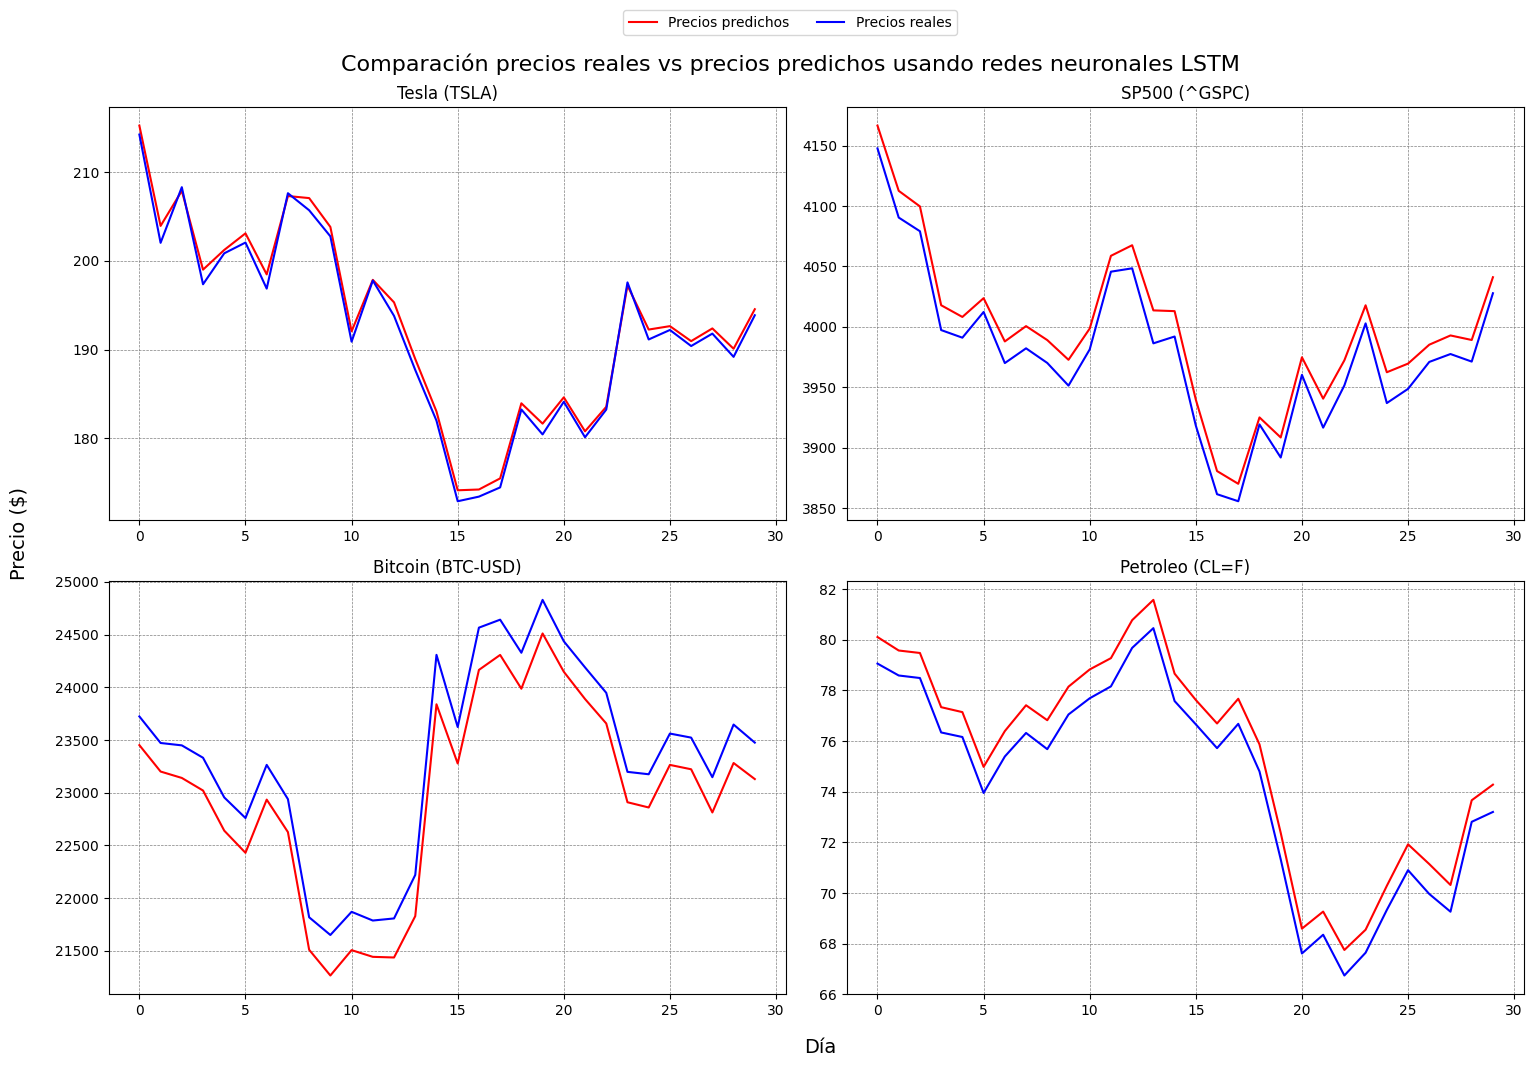

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = Sequential()
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_tesla.add(Dense(units = 1))

lstm_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_tesla, 'lstm_tesla.h5')


lstm_sp500 = Sequential()
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_sp500.add(Dense(units = 1))
lstm_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_sp500, 'lstm_sp500.h5')


lstm_bitcoin = Sequential()
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_bitcoin.add(Dense(units = 1))
lstm_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_bitcoin, 'lstm_bitcoin.h5')


lstm_petroleo = Sequential()
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_petroleo.add(Dense(units = 1))
lstm_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_petroleo, 'lstm_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  12.375056469702962
MSE:  153.14202262833714
MAE:  9.88640340169271
R²:  -2.491732503085702


SP500 (^GSPC)
RMSE:  136.24378435052301
MSE:  18562.36877415182
MAE:  128.56933593750003
R²:  -13.047119400137179


Bitcoin (BTC-USD)
RMSE:  1631.8191929921663
MSE:  2662833.8786176047
MAE:  1448.760546875
R²:  -0.2132362624239985


Petroleo (CL=F)
RMSE:  5.040062850545184
MSE:  25.402233537445646
MAE:  4.684150695800784
R²:  -1.2519006310416918




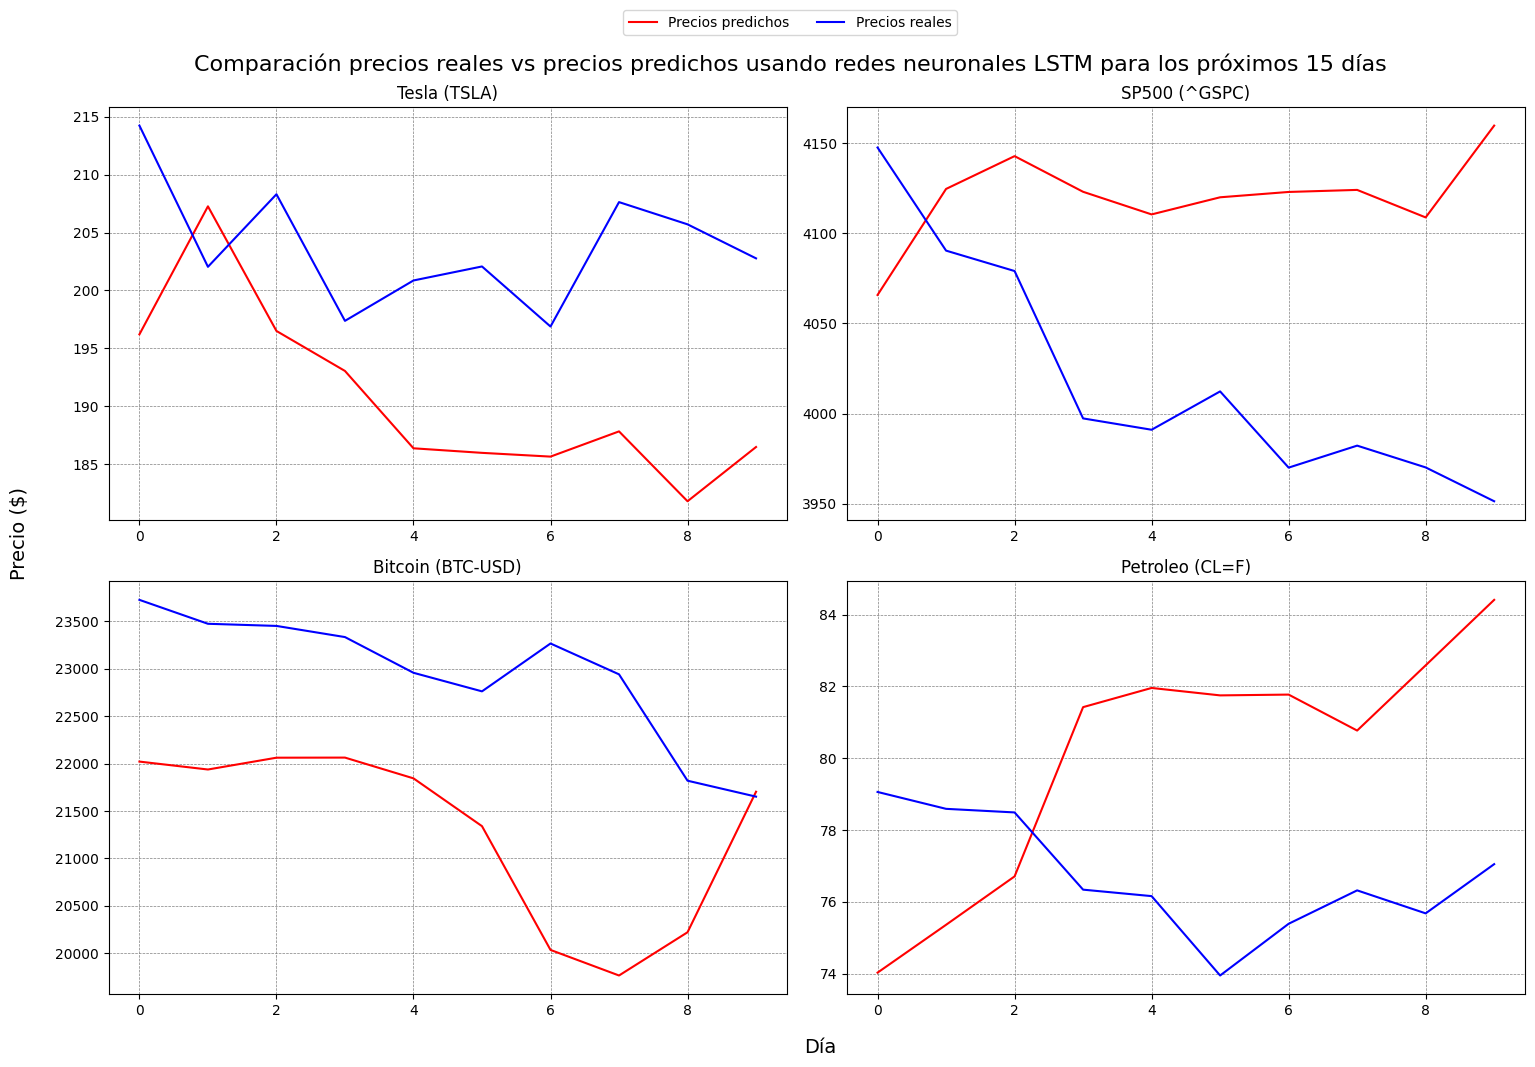

In [32]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# GRU

In [25]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

In [26]:
def create_gru(units, activation):
    model = Sequential()
    model.add(GRU(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_tesla = KerasRegressor(build_fn=create_gru)
gru_sp500 = KerasRegressor(build_fn=create_gru)
gru_bitcoin = KerasRegressor(build_fn=create_gru)
gru_petroleo = KerasRegressor(build_fn=create_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_1400\1278804985.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_tesla = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_1400\1278804985.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_sp500 = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_1400\1278804985.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_bitcoin = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppD

70/70 [==============================] - 18s 226ms/step - loss: 0.0194
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 512}
Mejor resultado para Tesla:  0.9909879809464547
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 512}
Mejor resultado para SP500:  0.9945934435024851
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 512}
Mejor resultado para Bitcoin:  0.96917563515512
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.9873425712554352


2/2 [==============================] - 0s 26ms/step
Tesla (TSLA)
RMSE:  6.6878791322135465
MSE:  44.72772728709742
MAE:  5.327604705212163
R²:  0.7683176925845232


2/2 [==============================] - 0s 10ms/step
SP500 (^GSPC)
RMSE:  38.39981021320207
MSE:  1474.5454244099383
MAE:  29.34120327818625
R²:  0.7931266985946036


3/3 [==============================] - 0s 42ms/step
Bitcoin (BTC-USD)
RMSE:  1076.0769267578476
MSE:  1157941.552300614
MAE:  935.7733058286517
R²:  0.870332925185359


2/2 [==============================] - 0s 28ms/step
Petroleo (CL=F)
RMSE:  4.300653999673718
MSE:  18.495624824909545
MAE:  3.989992141723636
R²:  -0.015735948290365176




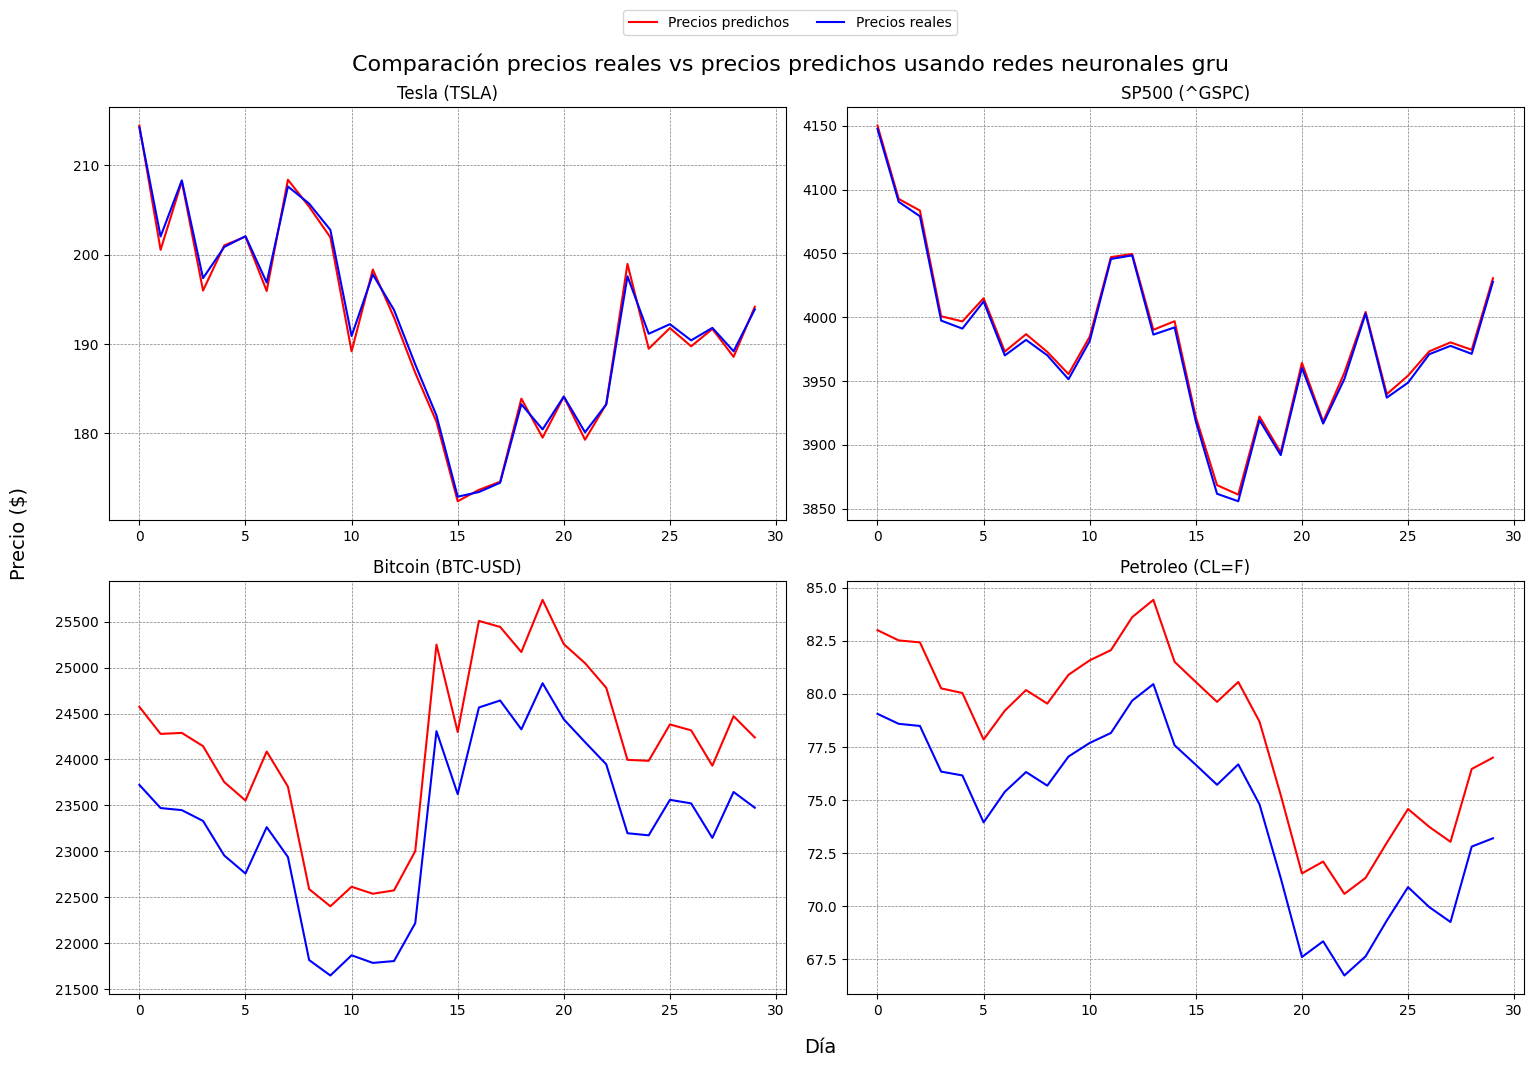

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = Sequential()
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
gru_tesla.add(Dense(units = 1))

gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(gru_tesla, 'gru_tesla.h5')


gru_sp500 = Sequential()
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_sp500.add(Dense(units = 1))
gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(gru_sp500, 'gru_sp500.h5')


gru_bitcoin = Sequential()
gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
gru_bitcoin.add(Dense(units = 1))
gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(gru_bitcoin, 'gru_bitcoin.h5')


gru_petroleo = Sequential()
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
gru_petroleo.add(Dense(units = 1))
gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(gru_petroleo, 'gru_petroleo.h5')

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  11.390912406757947
MSE:  129.75288545843213
MAE:  9.33693644205729
R²:  -73.92063271404248


SP500 (^GSPC)
RMSE:  148.52002594329676
MSE:  22058.198106197542
MAE:  137.89539388020842
R²:  -247.51502965441944


Bitcoin (BTC-USD)
RMSE:  11286.43349342566
MSE:  127383581.00152054
MAE:  9370.535807291666
R²:  -2.606605714192836


Petroleo (CL=F)
RMSE:  40.12934839753193
MSE:  1610.3646028104981
MAE:  35.863190205891925
R²:  -3.789631758599703




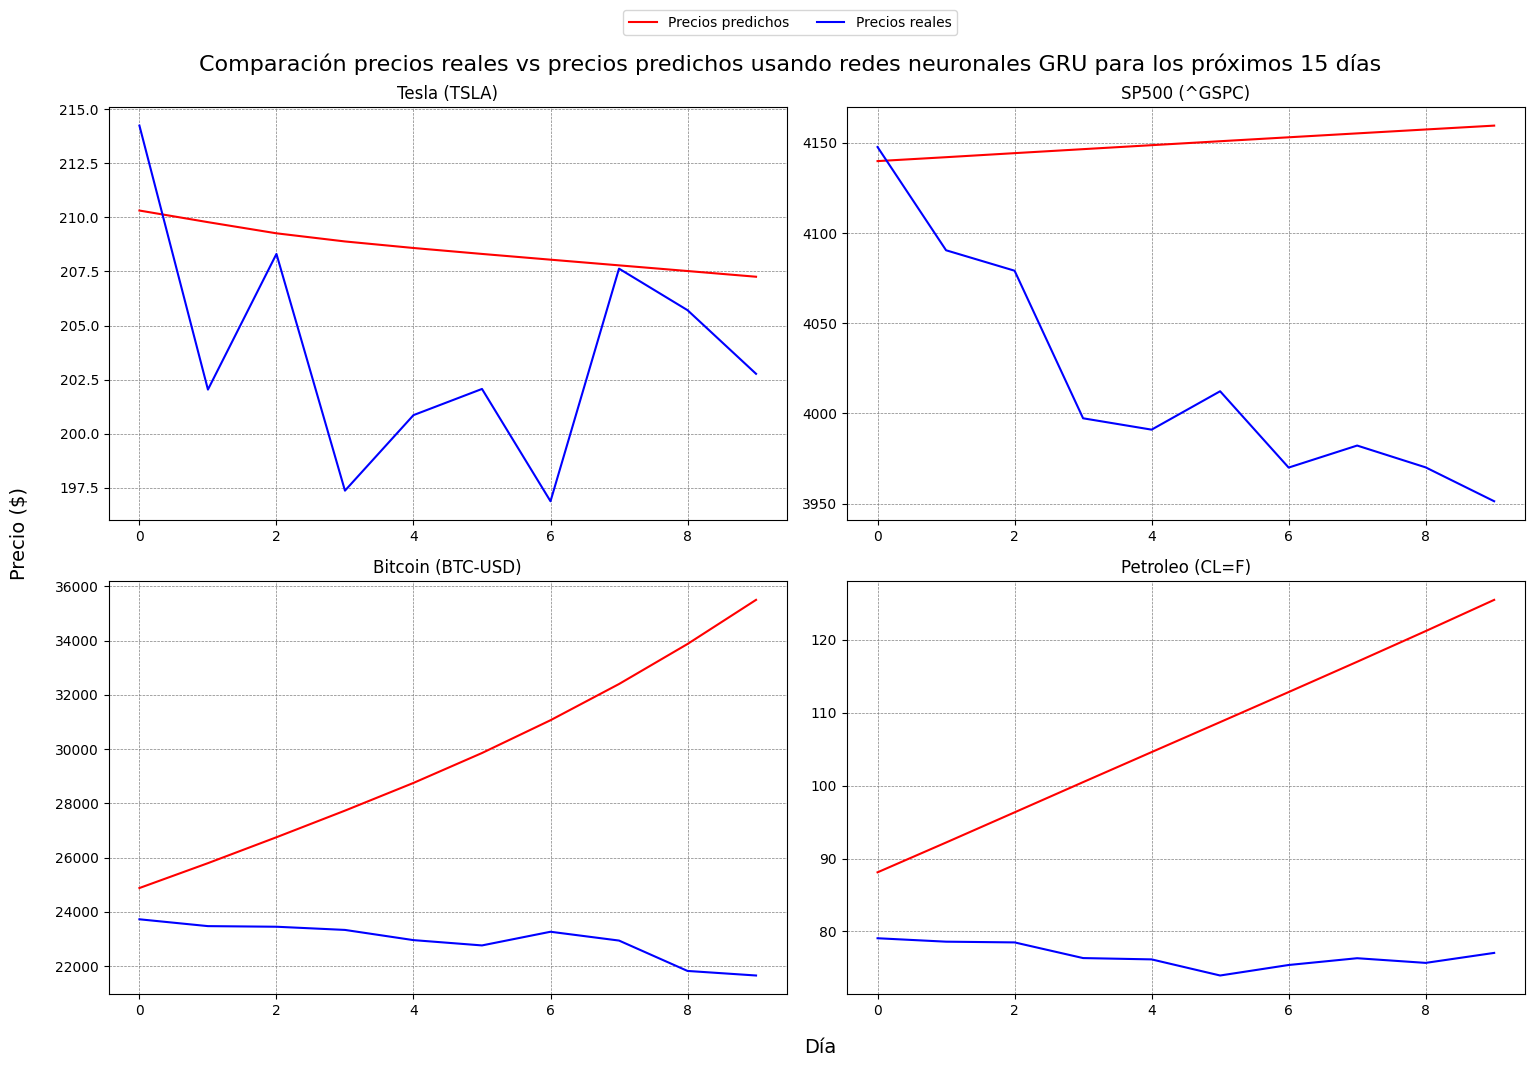

In [34]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM + GRU

In [35]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [36]:
def create_lstm_gru(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_petroleo = KerasRegressor(build_fn=create_lstm_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}


grid_search_tesla = GridSearchCV(estimator=lstm_gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_sp500 = GridSearchCV(estimator=lstm_gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_bitcoin = GridSearchCV(estimator=lstm_gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_petroleo = GridSearchCV(estimator=lstm_gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_1400\202839310.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_1400\202839310.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_1400\202839310.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
C:\Us

Fitting 3 folds for each of 16 candidates, totalling 48 fits
66/66 [==============================] - 38s 331ms/step - loss: 0.0262
Fitting 3 folds for each of 16 candidates, totalling 48 fits
70/70 [==============================] - 46s 343ms/step - loss: 0.0268
Fitting 3 folds for each of 16 candidates, totalling 48 fits
49/49 [==============================] - 8s 80ms/step - loss: 0.0133
Fitting 3 folds for each of 16 candidates, totalling 48 fits
70/70 [==============================] - 31s 354ms/step - loss: 0.0156
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9756942106099515
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 256}
Mejor resultado para SP500:  0.9891804914432107
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 128}
Mejor resultado para Bitcoin:  0.9163147766082416
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.9586059503089

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

2/2 [==============================] - 0s 9ms/step
Tesla (TSLA)
RMSE:  7.394770738443929
MSE:  54.68263427414657
MAE:  5.843883439606311
R²:  0.7019548384449412


2/2 [==============================] - 0s 19ms/step
SP500 (^GSPC)
RMSE:  39.20608202276984
MSE:  1537.1168675761564
MAE:  30.229094860600462
R²:  0.7884910203686821


3/3 [==============================] - 0s 9ms/step
Bitcoin (BTC-USD)
RMSE:  710.8244788519264
MSE:  505271.4397351127
MAE:  520.492648349719
R²:  0.9426359320221593


2/2 [==============================] - 0s 21ms/step
Petroleo (CL=F)
RMSE:  1.7451716320652475
MSE:  3.0456240253652798
MAE:  1.4138861436110266
R²:  0.8273230545493038




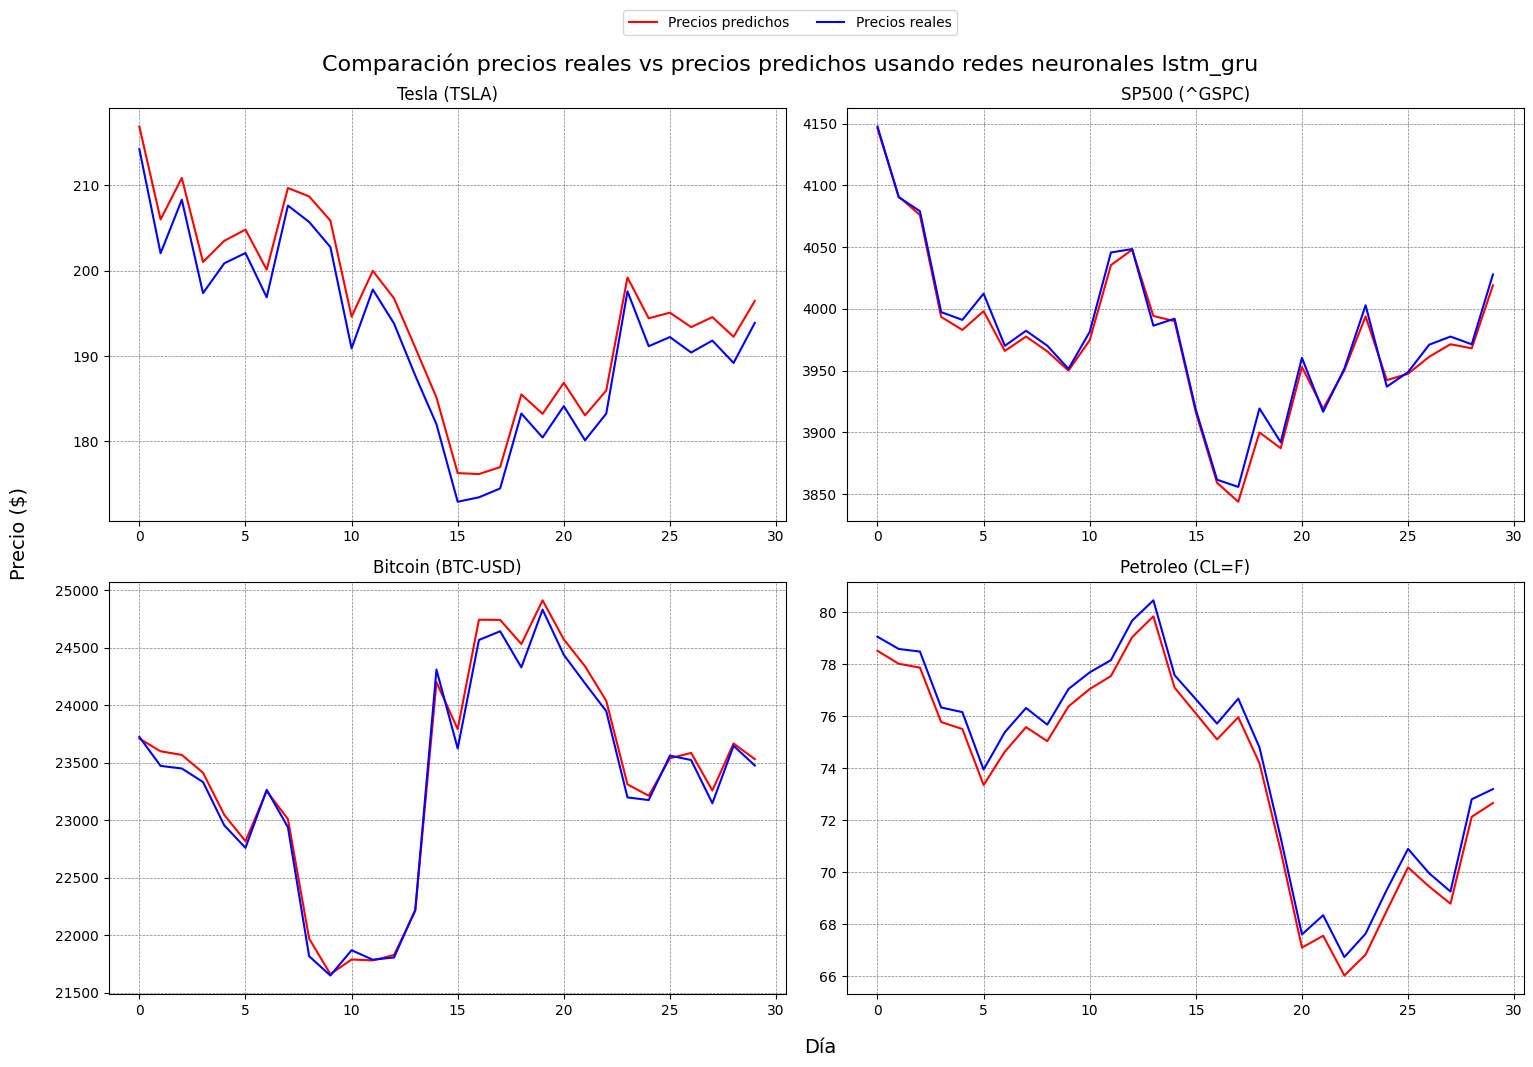

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = Sequential()
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_gru_tesla.add(Dense(units = 1))
lstm_gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_gru_tesla, 'lstm_gru_tesla.h5')

lstm_gru_sp500 = Sequential()
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_gru_sp500.add(Dense(units = 1))
lstm_gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_gru_sp500, 'lstm_gru_sp500.h5')

lstm_gru_bitcoin = Sequential()
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_gru_bitcoin.add(Dense(units = 1))
lstm_gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_gru_bitcoin, 'lstm_gru_bitcoin.h5')


lstm_gru_petroleo = Sequential()
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_gru_petroleo.add(Dense(units = 1))
lstm_gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_gru_petroleo, 'lstm_gru_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  36.689459737795815
MSE:  1346.11645585134
MAE:  31.828310139973958
R²:  -8.325952897224555


SP500 (^GSPC)
RMSE:  99.38286132383489
MSE:  9876.953124912598
MAE:  89.92750651041676
R²:  -24.61536318889132


Bitcoin (BTC-USD)
RMSE:  1432.99696948682
MSE:  2053480.3145584106
MAE:  1107.746875
R²:  -15.630655920650607


Petroleo (CL=F)
RMSE:  4.135983948890507
MSE:  17.106363225479914
MAE:  3.002642822265626
R²:  -1.295084522970543




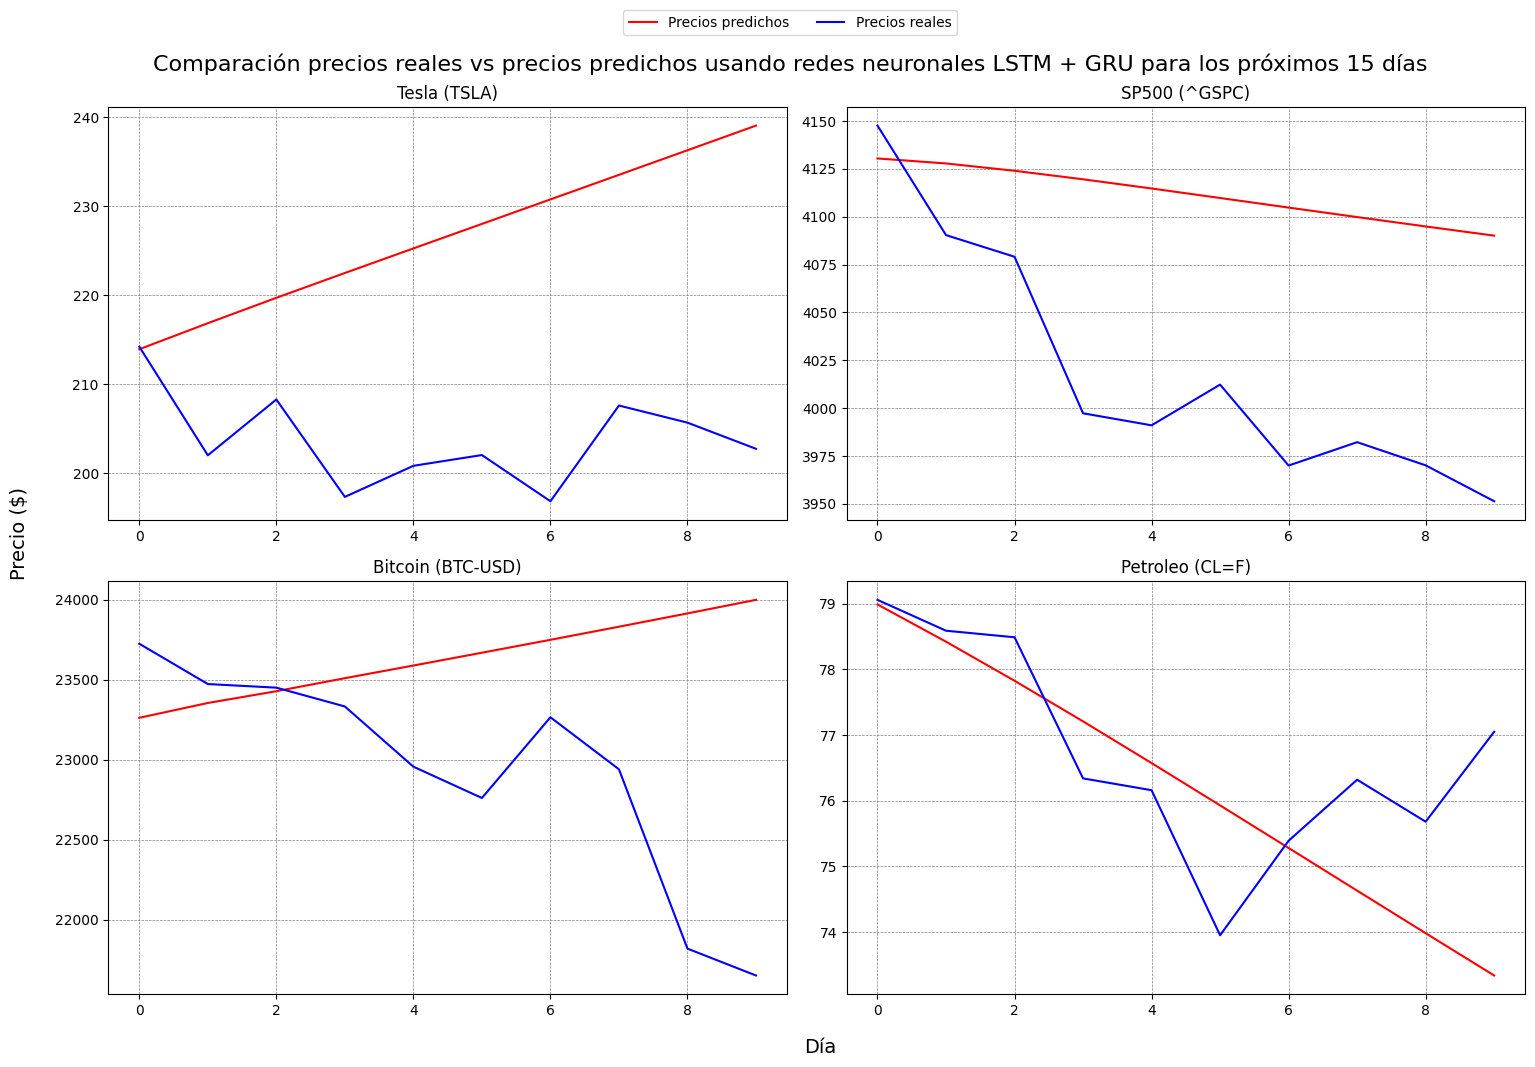

In [36]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()